In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from TileCoding import *
import warnings
import math
import itertools
from collections import namedtuple
import sys
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

TensorFlow 1.x selected.


In [ ]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 3000  # Increase upper time limit so we can plot full behaviour.
np.random.seed(6)  # Make plots reproducible

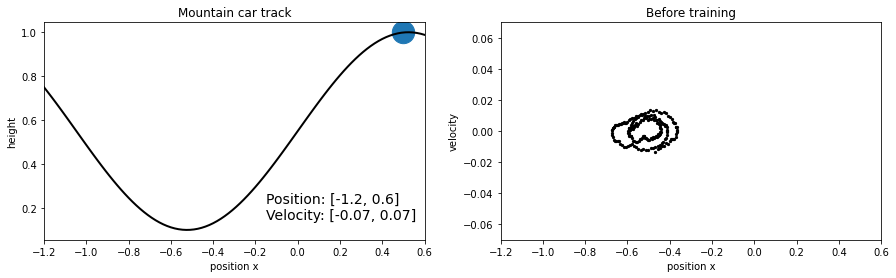

In [ ]:
"""
Exploratory analysis
"""

fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (15, 4))

# Figure 1 - the environment of the moutaincar
x = np.linspace(-1.2,0.6,100)
ax0.plot(x, np.sin(3 * x) * 0.45 + 0.55, 'k-', lw = 2)
ax0.scatter(0.5, 1, s = 500)
ax0.set_title('Mountain car track')
ax0.set_xlabel('position x')
ax0.set_ylabel('height')
ax0.set_xlim(-1.2, 0.6)

# Insert text
space_low = env.observation_space.low
space_high = env.observation_space.high
pos = [space_low[0], space_high[0]]
vel = [space_low[1], space_high[1]]
ax0.text(-0.15, 0.15, 'Position: %s \nVelocity: %s' % (pos, vel), fontsize = 14)

# Figure 2 - the result from a series of random actions
def random_actions(): # Get data from a series random actions
    observation = env.reset()
    pos, vel = [], []
    env.seed(0)
    env.reset()
    for timestamp in range(200):
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        pos.append(observation[0])
        vel.append(observation[1])
    return pos, vel

pos, vel = random_actions()
ax1.scatter(pos, vel, color = 'k', s = 5)
ax1.set_title('Before training')
ax1.set_xlabel('position x')
ax1.set_ylabel('velocity')
ax1.set_xlim(-1.2, 0.6)
ax1.set_ylim(-0.07, 0.07)
env.close()

In [ ]:
class SARSALamda():

    """ Implementation of SARSA algorithm"""

    def __init__(self, step_size = 1, lam = 0.95, num_tilings = 8, max_size = 4096, gamma = 1, epsilon = 0):

        """
        Initalize hyperparameters
        """

        self.step_size = step_size
        self.lam = lam
        self.num_tilings = num_tilings
        self.max_size = max_size
        self.discount_factor = gamma
        self.epsilon = epsilon
        self.action_space = env.action_space.n

        self.learning_rate = self.step_size / self.num_tilings # learning rate for each tile
        self.iht = IHT(max_size) # Initialize index hash table (IHT) for tile coding
        self.weights = np.zeros(max_size) # weight for each tile
        self.z = np.zeros(max_size) # trace vector

        self.position_scale = self.num_tilings / (env.observation_space.high[0] \
                                                  - env.observation_space.low[0])
        self.velocity_scale = self.num_tilings / (env.observation_space.high[1] \
                                                  - env.observation_space.low[1])
        
    def featurize_state_action(self, state, action):

        """
        Returns the featurized representation for a 
        state-action pair.
        """

        featurized = tiles(self.iht, self.num_tilings, 
                           [self.position_scale * state[0], 
                            self.velocity_scale * state[1]], 
                           [action])
        return featurized

    def predict(self, state, action):

        """
        Estimate the value of given state and action
        """

        features = [self.featurize_state_action(state, action)]
            
        return np.sum(self.weights[features])

    def policy(self, state):

        """
        ε-Greedy Policy Exploration
        """

        actions = np.ones(self.action_space, dtype = float) * self.epsilon / self.action_space
        best_action = np.argmax([self.predict(state, action) for action in range(self.action_space)])
        actions[best_action] += (1.0 - self.epsilon)
        action = np.random.choice(self.action_space, p = actions)
        return action
        
    def update(self, state, action, reward, next_state, next_action):

        """
        Learn with given state, action and target
        """

        estimation = self.predict(state, action)
        Q_new = self.predict(next_state, next_action)
        target = reward + self.discount_factor * Q_new
        delta = target - estimation
        
        features = [self.featurize_state_action(state, action)]
        active = np.isin(range(len(self.z)), features)
        self.z[active] = 1
        self.z[~active] *= self.discount_factor * self.lam

        self.weights += self.learning_rate * delta * self.z 
        
    def reset(self):

        """
        Resets the eligibility trace (must be done at the start of every epoch) and 
        optionally the weight vector if we want to restart training
        from scratch.
        """

        self.z = np.zeros(self.max_size)

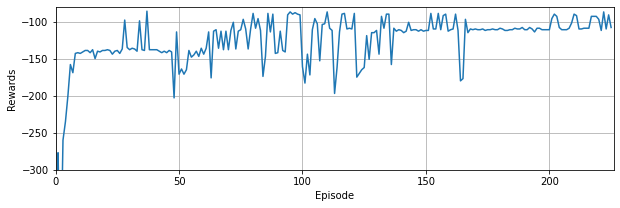

In [ ]:
def train(model, episodes):

    """
    Train the model to interact with and learn from the environment
    """
    
    loss = []  
    for episode in range(episodes):
        env.seed(episode)
        model.reset() # reset the eligibility trace
   
        # Reset the environment and pick the first action
        state = env.reset()
        action = model.policy(state)
        
        score = 0
        while True:
            next_state, reward, done, _ = env.step(action)
            next_action = model.policy(next_state)
            model.update(state, action, reward, next_state, next_action)
            state = next_state 
            action = next_action
            score += reward
            if done:
                break                  
        env.close()
        loss.append(score)

        # Early stop 
        if np.average(loss[-100:]) >= -110:
            break

    return loss, model

if __name__ == '__main__':
    model = SARSALamda() 
    episodes = 500
    loss, agent = train(model, episodes)
    
    ### Visualize the process of training model
    plt.subplots(figsize= (10, 3))
    plt.plot(list(range(len(loss))), loss, label = 'Training')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.xlim(0, len(loss))
    plt.ylim(-300, -80)
    plt.grid(True)
    plt.show()

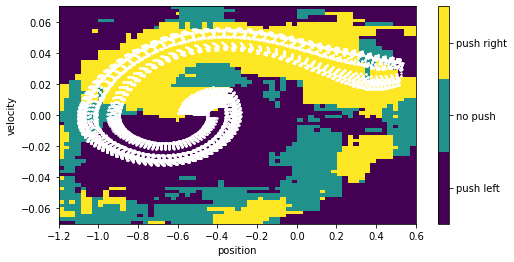

In [ ]:
# Visualization of policy
fig, ax = plt.subplots(figsize = (8, 4))
poses = np.linspace(env.unwrapped.min_position, env.unwrapped.max_position, 128)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 128)
positions, velocities = np.meshgrid(poses, vels)

@np.vectorize
def decide(position, velocity):
    return agent.policy(np.array([position, velocity]))
action_values = decide(positions, velocities)    
c = plt.pcolormesh(positions, velocities, action_values)

states = []
episodes = 100
for episode in range(episodes):
      env.seed(episode)
      state = env.reset()
      action = agent.policy(state)
      while True:
          next_state, reward, done, _ = env.step(action)
          next_action = agent.policy(next_state)
          state = next_state 
          action = next_action

          states.append(state)
          # The episode is done when the agent reaches the goal or maximum episode
          if done: 
              break
      env.close()

pos = [s[0] for s in states]
vel = [s[1] for s in states]
ax.scatter(pos, vel, s = 2, color = 'w')

cbar = fig.colorbar(c, ax = ax, boundaries = [-.5, .5, 1.5, 2.5], ticks = [0, 1, 2])
cbar.ax.set_yticklabels(['push left', 'no push', 'push right'])
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.show()